In [2]:
import cPickle as pickle
from matplotlib import pyplot as plt
import os
import numpy as np

# Grab Input Data
labels_file = '../image_dump/train_test_list.txt'
data_files_path = '../../VOC2012/fc7_features/'

data = []
labels = []
data_files = []
with open(labels_file) as f:
    for line in f:
        data_file, label = line.split(' ')
        data_file = data_file.split('/')[-1].split('.')[0] + '.pi'
        try:
            data.append(pickle.load(open(data_files_path + data_file, 'rb')))
            labels.append(int(label))
            data_files.append(data_file)
        except IOError as e:
            pass
data = np.squeeze(np.array(data))
labels = np.array(labels)
data_files = np.array(data_files)
print data.shape, labels.shape, data_files.shape

(36304, 4096) (36304,) (36304,)


In [27]:
# Split data into training and test
num_vectors = data.shape[0]
test_ratio = .2
num_test = num_vectors * test_ratio

indices = np.random.permutation(num_vectors)
training_idx, test_idx = indices[num_test:], indices[:num_test]
training_data, test_data = data[training_idx,:], data[test_idx,:]
training_labels, test_labels = labels[training_idx,], labels[test_idx,]

print training_data.shape, test_data.shape
print training_labels.shape, test_labels.shape

(29044, 4096) (7260, 4096)
(29044,) (7260,)


In [31]:
# Define Classifier
# http://scikit-learn.org/stable/modules/grid_search.html
from sklearn import svm, neighbors, linear_model, ensemble, grid_search 

scoring = 'f1_weighted'
class_weight = 'subsample' # 'subsample' (forests only), 'auto'

classifier = ensemble.RandomForestClassifier(n_estimators=20, max_depth=15, class_weight=class_weight)
# classifier = grid_search.GridSearchCV(svm.LinearSVC(class_weight=class_weight), {'C':[.01, .1, 1, 10, 100]}, scoring=scoring)

# classifier = linear_model.RidgeClassifierCV()
# classifier = linear_model.SGDClassifier()
# classifier = ensemble.AdaBoostClassifier()
# classifer = ensemble.GradientBoostingClassifier()
# classifer = ensemble.ExtraTreesClassifier()

## Slow
# classifier = grid_search.GridSearchCV(svm.SVC(class_weight=class_weight), {'kernel':('linear','rbf'), 'C':[.01, .1, 1, 10, 100]}, scoring=scoring)
# classifier = neighbors.KNeighborsClassifier()

In [32]:
%%time
# Train Classifier
classifier.fit(training_data, training_labels);

CPU times: user 16.8 s, sys: 50.6 ms, total: 16.9 s
Wall time: 16.9 s


RandomForestClassifier(bootstrap=True, class_weight='subsample',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
# Test Classifier
from sklearn.cross_validation import cross_val_score

predicted_labels = classifier.predict(test_data)
print classifier.score(training_data, training_labels) # score is always accuracy
print cross_val_score(classifier, training_data, training_labels, scoring=scoring)
print classifier.score(test_data, test_labels) # score is always accuracy

0.990152871505
[ 0.93525326  0.93709786  0.93961843]
0.942011019284


In [34]:
import pandas
from sklearn.metrics import confusion_matrix
wrong_test_idx = np.arange(test_labels.shape[0])[predicted_labels != test_labels]
wrong_data_files_idx = test_idx[wrong_test_idx]
wrong_data_files = data_files[wrong_data_files_idx]

wrong_predicted = predicted_labels[predicted_labels != test_labels]
wrong_true = test_labels[predicted_labels != test_labels]

# Labels 0-5 = background, person, bike, bus, car, motorbike
print "Training Confusion Matrix"
print confusion_matrix(training_labels, classifier.predict(training_data))
print "Test Results"
print "Wrong:", len(wrong_true), '/', len(test_labels), ',', float(len(wrong_true))/len(test_labels)
print confusion_matrix(test_labels, predicted_labels)
print pandas.DataFrame({"Image Index": wrong_data_files, "Predicted": wrong_predicted, "Truth": wrong_true})

Training Confusion Matrix
[[11077   103     0     0    38     0]
 [   85 13866     1     0    17    13]
 [    3     4   664     0     0     0]
 [    0     0     0   530     0     0]
 [   13     5     0     0  1981     2]
 [    1     1     0     0     0   640]]
Test Results
Wrong: 421 / 7260 , 0.0579889807163
[[2777   60    1    1   30    1]
 [  82 3313    1    0   16    7]
 [  14   24  120    0    2    6]
 [  26    1    0  111   17    0]
 [  41   30    2    2  412    4]
 [   4   33    6    0   10  106]]
       Image Index  Predicted  Truth
0    pict_13064.pi          0      1
1    pict_27266.pi          1      0
2    pict_11446.pi          1      4
3     pict_3546.pi          0      1
4     pict_6778.pi          0      4
5     pict_3599.pi          0      1
6    pict_22336.pi          1      0
7     pict_1783.pi          0      1
8     pict_4201.pi          1      5
9     pict_9376.pi          1      5
10   pict_10400.pi          5      2
11    pict_1199.pi          5      1
12    pict

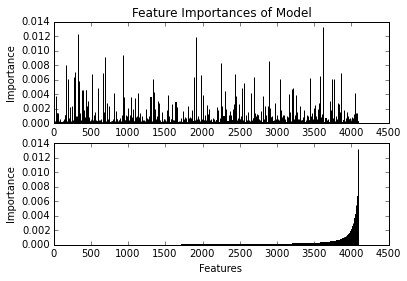

In [35]:
%matplotlib inline
# Visualize Feature Importances
# Forest/Tree Classifiers only
import matplotlib.pyplot as plt

importances = classifier.feature_importances_

width = 0.35       # the width of the bars
plt.subplot(211)
plt.bar(np.arange(importances.shape[0]), importances, width, color='r')
plt.title("Feature Importances of Model")
plt.ylabel("Importance")
plt.subplot(212)
plt.bar(np.arange(importances.shape[0]),sorted(importances), width, color='r')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [36]:
import pickle
# Export model
svm_classifier = grid_search.GridSearchCV(svm.LinearSVC(class_weight='auto'), {'C':[.01, .1, 1, 10, 100]}, scoring=scoring)
svm_classifier.fit(training_data, training_labels);
print svm_classifier.score(test_data, test_labels)
pickle.dump(svm_classifier, open('svm_fc7_with_bg_model', 'wb'))

0.962525943336


/Users/alvinyuan/Documents/Vision/smartCams/venv/lib/python2.7/site-packages/sklearn/grid_search.py:370: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [37]:
forest_classifier = ensemble.RandomForestClassifier(n_estimators=20, max_depth=15, class_weight='subsample')
forest_classifier.fit(training_data, training_labels);
print forest_classifier.score(test_data, test_labels)
pickle.dump(forest_classifier, open('forest_fc7_with_bg_model', 'wb'))

0.934986225895
